In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [13]:
Input_size_Mine = 4
class Mine(nn.Module):
    def __init__(self, input_size=Input_size_Mine, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [14]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [16]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
        for i in range(2, Input_size_Mine):
            marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            batch = np.append(batch, data[marginal_index][:,i].reshape(-1,1), axis=1)
    return batch

In [18]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3), verbose=True):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if verbose and (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [20]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
import DiscreteCondEnt as DC


from sklearn.linear_model import LinearRegression
linReg = LinearRegression()

def varEntropy(y):
    return np.log(np.var(y)*3.14159*2)/2


from sklearn.metrics import mean_squared_error
def MSEscorer(clf, X, y):
    y_est = clf.predict(X)
    return np.log(mean_squared_error(y, y_est)*3.14159*2)/2

GT2_const = Input_size_Mine * 0.5 * np.log(2*np.pi*np.e)

CVFold = 3
MINE2 = []
LinReg2 = []
GT2 = []
#COV2 = []
#for i in range(1, 16):
#    cov = 1 - 0.1**
#    COV2.append(cov)i
COV2 = np.linspace(0, 0.9, 5)
for cov in COV2:
    Gaussian_cov = [[1,0,0,cov],[0,1,cov,0],[0,cov,1,0],[cov,0,0,1]]
    x = np.transpose(np.random.multivariate_normal( mean=[0,0,0,0],
                                  cov=Gaussian_cov,
                                 size = 300))
    DE = DC.computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)
#     MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
#     MI = MI/2
    numVar = DE.shape[0]
    MI = np.sum(DE[:,0]) - np.sum(DE[:,-1])
    LinReg2.append(MI)
    
    #groundTruth = -0.5*np.log(1-cov*cov)
    groundTruth = -0.5*np.log(np.linalg.det(np.array(Gaussian_cov)))
    GT2.append(groundTruth)
    
    #MINE
    mine_net = Mine()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(np.transpose(x),mine_net,mine_net_optim)
    result_ma = ma(result)
    MINE2.append(result_ma[-1])
    #MINE

-9.580872e-06
0.00040629238
6.489642e-05
-0.0002762208
-1.3079029e-05
0.07905992
0.04820303
0.015935868
0.044647183
-0.015066311
0.35370535
0.2137784
0.035675287
0.49222293
0.4272037
0.36529073
0.57871044
0.8146284
0.68817943
0.5431146
1.7619507
1.5652692
2.110762
1.7736164
2.0277045


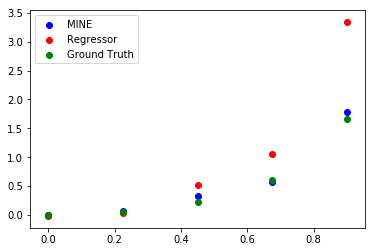

In [26]:
fig, ax = plt.subplots()

ax.scatter(COV2, MINE2, c='b', label='MINE')
ax.scatter(COV2, LinReg2, c='r', label='Regressor')
ax.scatter(COV2, GT2, c='g', label='Ground Truth')

ax.legend()
plt.show()

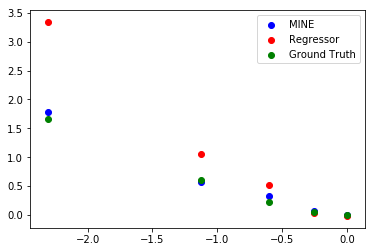

In [27]:
fig2, ax2 = plt.subplots()
COV22 = np.log(np.ones(len(COV2)) - COV2)
ax2.scatter(COV22, MINE2, c='b', label='MINE')
ax2.scatter(COV22, LinReg2, c='r', label='Regressor')
ax2.scatter(COV22, GT2, c='g', label='Ground Truth')

ax2.legend()
plt.show()